# Time delay-cosmography simulations

This notebook requires standard python libraries and the publicly available packages on github:

- lenstronomy (https://github.com/sibirrer/lenstronomy) (pip install lenstronomy)
- fastell4py (only when using the SPEMD model) (https://github.com/sibirrer/fastell4py), based on the original fastell fortran code (by Barkana)

Installation for each package can be found on the github page.
WARNING: a proper installation of fastell4py needs a fortran compiler.
This notebook has been tested with lenstronomy 1.2.0.

For further information, please get in touch with the author of this notebook, Simon Birrer: sibirrer@gmail.com

In [1]:
# import of standard python libraries
import numpy as np
import os
import time
import corner
import copy
import astropy.io.fits as pyfits

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
from lenstronomy.Util import mask_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

## simulation choices

In [2]:
np.random.seed(41)
# define lens configuration and cosmology (not for lens modelling)
z_lens = 0.5
z_source = 1.5
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)


# import PSF file
#path = os.getcwd()
#dirpath, _ = os.path.split(path)
#module_path, _ = os.path.split(dirpath)
#psf_filename = os.path.join(module_path, 'Data/PSF_TinyTim/psf_example.fits')
#kernel = pyfits.getdata(psf_filename)

#plt.matshow(np.log10(kernel))
#plt.show()

    
# data specifics
sigma_bkg = .05  #  background noise per pixel (Gaussian)
exp_time = 100.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF (only valid when psf_type='gaussian')
psf_type = 'GAUSSIAN'  # 'GAUSSIAN', 'PIXEL', 'NONE'
kernel_size = 91
#kernel_cut = kernel_util.cut_psf(kernel, kernel_size)

# initial input simulation

# generate the coordinate grid and image properties
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, sigma_bkg)
data_class = ImageData(**kwargs_data)
# generate the psf variables

kwargs_psf = {'psf_type': psf_type, 'pixel_size': deltaPix, 'fwhm': fwhm}
#kwargs_psf = sim_util.psf_configure_simple(psf_type=psf_type, fwhm=fwhm, kernelsize=kernel_size, deltaPix=deltaPix, kernel=kernel)
psf_class = PSF(**kwargs_psf)

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in log10


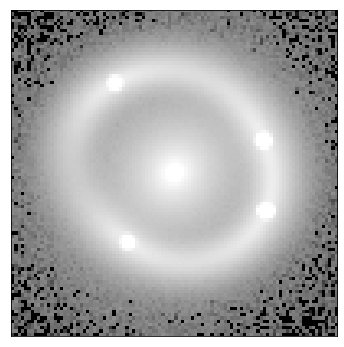

In [3]:
# lensing quantities
s_scale = 0.03  # core size of lens profile
gamma1, gamma2 = param_util.shear_polar2cartesian(gamma=0.06, phi=-0.5)
kwargs_shear = {'gamma1': gamma1, 'gamma2': gamma2}  # shear values to the source plane
kwargs_spemd = {'theta_E': 1.66, 'gamma': 2.08, 's_scale': s_scale, 'center_x': 0.0, 'center_y': 0.0, 'e1': 0.05, 'e2': 0.05}  # parameters of the deflector lens model

# the lens model is a supperposition of an elliptical lens model with external shear
lens_model_list = ['SPEMD_SMOOTH', 'SHEAR']
kwargs_lens = [kwargs_spemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list, z_lens=z_lens, z_source=z_source, cosmo=cosmo)

# choice of source type
source_type = 'SERSIC'  # 'SERSIC' or 'SHAPELETS'

source_x = 0.
source_y = 0.1


# Sersic parameters in the initial simulation
phi_G, q = 0.5, 0.8
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_source = {'amp': 4000, 'R_sersic': 0.2, 'n_sersic': 1, 'e1': e1, 'e2': e2, 'center_x': source_x, 'center_y': source_y}
#kwargs_else = {'sourcePos_x': source_x, 'sourcePos_y': source_y, 'quasar_amp': 400., 'gamma1_foreground': 0.0, 'gamma2_foreground':-0.0}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic_source]
source_model_class = LightModel(light_model_list=source_model_list)


# lens light model
phi_G, q = 0.9, 0.9
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_lens = {'amp': 8000, 'R_sersic': 0.4, 'n_sersic': 2., 'e1': e1, 'e2': e2, 'center_x': 0.0, 'center_y': 0}
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [kwargs_sersic_lens]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(source_x, source_y, kwargs_lens, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': np.abs(mag)*1000}]  # quasar point source position in the source plane and intrinsic brightness
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

kwargs_numerics = {'supersampling_factor': 1}

imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                lens_light_model_class, point_source_class, kwargs_numerics=kwargs_numerics)

# generate image
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=sigma_bkg)
image_sim = image_sim + bkg + poisson

data_class.update_data(image_sim)
kwargs_data['image_data'] = image_sim


# display the initial simulated image
cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 2

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
ax = axes
im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()

## time delays
time delays are defined in **lenstronomy** as the difference in light travel path relative to a straight line. Negative values correspond to earlier arrival times. The units are in days.

In [4]:
kwargs_model = {'lens_model_list': lens_model_list, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                'point_source_model_list': point_source_list,
                 }

from lenstronomy.Analysis.td_cosmography import TDCosmography
td_cosmo = TDCosmography(z_lens, z_source, kwargs_model, cosmo_fiducial=cosmo)

# time delays, the unit [days] is matched when the lensing angles are in arcsec
t_days = td_cosmo.time_delays(kwargs_lens, kwargs_ps, kappa_ext=0)
print("the time delays for the images at position ", kwargs_ps[0]['ra_image'], kwargs_ps[0]['dec_image'], "are: ", t_days)

# relative delays (observable). The convention is relative to the first image
dt_days =  t_days[1:] - t_days[0]
# and errors can be assigned to the measured relative delays (full covariance matrix not yet implemented)
dt_sigma = [3, 5, 2]  # Gaussian errors
# and here a realisation of the measurement with the quoted error bars
dt_measured = dt_days  #np.random.normal(dt_days, dt_sigma)
print("the measured relative delays are: ", dt_measured)

the time delays for the images at position  [-0.90513215  1.40083822  1.36703337 -0.71215407] [ 1.36847271 -0.58203804  0.48774901 -1.06481324] are:  [-86.6932859  -66.77890187 -64.84220143 -48.40316982]
the measured relative delays are:  [19.91438403 21.85108446 38.29011608]


## kinematics
Kinematics can provide important complementary information about the lens to constrain cosmography

In [5]:
# observational conditions of the spectroscopic campagne
R_slit = 1. # slit length in arcsec
dR_slit = 1.  # slit width in arcsec
psf_fwhm = 0.7

kwargs_aperture = {'aperture_type': 'slit', 'length': R_slit, 'width': dR_slit, 'center_ra': 0.05, 'center_dec': 0, 'angle': 0}
anisotropy_model = 'OsipkovMerritt'
aperture_type = 'slit'

kwargs_galkin_numerics = {'sampling_number': 10000, # numerical ray-shooting, should converge -> infinity
                          'interpol_grid_num': 1000,  # numerical interpolation, should converge -> infinity
                          'log_integration': True,  # log or linear interpolation of surface brightness and mass models
                           'max_integrate': 100, 'min_integrate': 0.001}  # lower/upper bound of numerical integrals

r_ani = 1.
r_eff = 0.2
kwargs_anisotropy = {'r_ani': r_ani}
kwargs_seeing = {'psf_type': 'GAUSSIAN', 'fwhm': psf_fwhm}

from lenstronomy.Analysis.kinematics_api import KinematicAPI
kin_api = KinematicAPI(z_lens, z_source, kwargs_model, cosmo=cosmo, lens_model_kinematics_bool=[True, False],
                 light_model_kinematics_bool=[True])

vel_disp = kin_api.velocity_dispersion_numerical(kwargs_lens, kwargs_lens_light, kwargs_anisotropy, kwargs_aperture,
                                      kwargs_seeing, anisotropy_model, r_eff=r_eff, theta_E=1.66, Hernquist_approx=True,
                                      kwargs_numerics=kwargs_galkin_numerics, MGE_mass=True, kwargs_mge_mass={'n_comp': 20}, kappa_ext=0)
print(vel_disp, 'velocity dispersion in km/s')

163.41159584207855 velocity dispersion in km/s


## Model and parameter choices

In [6]:
cored_model = False  # boolean, if True, models a cored power-law profile, if False, models a power-law profile only
mask_center = True  # boolean, if True, mask the center of the image to avoid central photons to be informative about the core radius

mask = np.ones_like(image_sim)
if mask_center is True:
    x_grid, y_grid = data_class.pixel_coordinates
    mask = mask_util.mask_center_2d(center_x=0, center_y=0, r=0.4, x_grid=x_grid, y_grid=y_grid)
image_likelihood_mask_list = [mask]

kwargs_model_fit = {
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                'point_source_model_list': point_source_list
                 }
if cored_model is True:
    kwargs_model_fit['lens_model_list'] = ['SPEMD_SMOOTH', 'SHEAR']
else:
    kwargs_model_fit['lens_model_list'] = ['SPEMD', 'SHEAR']

# lens model choicers
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({})
kwargs_spemd_init = copy.deepcopy(kwargs_spemd)
if cored_model is True:
    
    kwargs_lens_init.append(kwargs_spemd_init)
    #kwargs_lens_init.append(kwargs_spemd)
    kwargs_lens_sigma.append({'theta_E': .2, 's_scale': 0.01, 'e1': 0.1, 'e2': 0.1, 'gamma': 0.1, 'center_x': 0.01, 'center_y': 0.01})
    kwargs_lower_lens.append({'theta_E': 0.01, 's_scale': 0.0000001, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10, 'center_y': -10})
    kwargs_upper_lens.append({'theta_E': 10, 's_scale': 1., 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10, 'center_y': 10})
else:
    del kwargs_spemd_init['s_scale']
    kwargs_lens_init.append(kwargs_spemd_init)
    #kwargs_lens_init.append(kwargs_spemd)
    kwargs_lens_sigma.append({'theta_E': .2, 'e1': 0.1, 'e2': 0.1, 'gamma': 0.1, 'center_x': 0.01, 'center_y': 0.01})
    kwargs_lower_lens.append({'theta_E': 0.01, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10, 'center_y': -10})
    kwargs_upper_lens.append({'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10, 'center_y': 10})
    
fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append(kwargs_shear)
kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
kwargs_lower_lens.append({'gamma1': -0.3, 'gamma2': -0.3})
kwargs_upper_lens.append({'gamma1': 0.3, 'gamma2': 0.3})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({})
kwargs_lens_light_init.append({'R_sersic': 0.5, 'n_sersic': 1, 'e1': 0, 'e2': 0., 'center_x': 0, 'center_y': 0})
#kwargs_lens_light_init.append(kwargs_sersic_lens)
kwargs_lens_light_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})
kwargs_source_init.append({'R_sersic': 0.1, 'n_sersic': 1, 'e1': 0, 'e2': 0., 'center_x': 0, 'center_y': 0})
#kwargs_source_init.append(kwargs_sersic_source)
kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.05, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]


fixed_ps = [{}]
kwargs_ps_init = kwargs_ps
kwargs_ps_sigma = [{'ra_image': 0.01 * np.ones(len(x_image)), 'dec_image': 0.01 * np.ones(len(x_image))}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones(len(x_image)), 'dec_image': -10 * np.ones(len(y_image))}]
kwargs_upper_ps = [{'ra_image': 10* np.ones(len(x_image)), 'dec_image': 10 * np.ones(len(y_image))}]

fixed_cosmo = {}
kwargs_cosmo_init = {'D_dt': 5000}
kwargs_cosmo_sigma = {'D_dt': 10000}
kwargs_lower_cosmo = {'D_dt': 0}
kwargs_upper_cosmo = {'D_dt': 10000}
cosmo_params = [kwargs_cosmo_init, kwargs_cosmo_sigma, fixed_cosmo, kwargs_lower_cosmo, kwargs_upper_cosmo]

ps_params = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params,
                'special': cosmo_params}


In [15]:


# numerical options and fitting sequences

num_source_model = len(source_model_list)

kwargs_constraints = {'joint_source_with_point_source': [[0, 0]],
                      'num_point_source_list': [4],
                      'solver_type': 'PROFILE_SHEAR',  # 'PROFILE', 'PROFILE_SHEAR', 'ELLIPSE', 'CENTER'
                      'Ddt_sampling': True,
                      }

kwargs_likelihood = {'check_bounds': True,
                     'force_no_add_image': False,
                     'source_marg': False,
                     'position_uncertainty': 0.004,
                     'check_solver': True,
                     'solver_tolerance': 0.001,
                     'time_delay_likelihood': True,
                     'image_likelihood_mask_list': image_likelihood_mask_list
                     }

image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear',
                    'time_delays_measured': dt_measured,
                    'time_delays_uncertainties': dt_sigma,}

from lenstronomy.Workflow.fitting_sequence import FittingSequence

mpi = False  # MPI possible, but not supported through that notebook.

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model_fit, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': .1, 'n_particles': 200, 'n_iterations': 200}],
        ['MCMC', {'n_burn': 400, 'n_run': 400, 'walkerRatio': 10, 'sigma_scale': .1}]
]

start_time = time.time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
max iteration reached! stoping
-1.0152117753709984 reduced X^2 of best position
-4957.78670502427 logL
9767 effective number of data points
[{'theta_E': 1.4661656089084758, 'gamma': 1.8474337192840995, 'e1': 0.05294262074794418, 'e2': 0.0534055024425774, 'center_x': -6.938545369163418e-05, 'center_y': 0.0002466882025511341}, {'gamma1': 0.036017108121302883, 'gamma2': -0.03736057656944614, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.1773970704971253, 'n_sersic': 1.0033140528751663, 'e1': 0.05878720373963159, 'e2': 0.09070793652271511, 'center_x': -8.96701551773571e-05, 'center_y': 0.08922524790330512}] source result
[{'amp': 1, 'R_sersic': 0.40699575907771274, 'n_sersic': 2.0124405866423065, 'e1': -0.011129390124613565, 'e2': 0.05199912525583698, 'center_x': -0.0006206658322039471, 'center_y': -0.00016674601493032353}] lens light result
[{'ra_image': array([-0.90519964,  1.4008

## analyse model output

-1.0126180754096696 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.0333772883485375


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


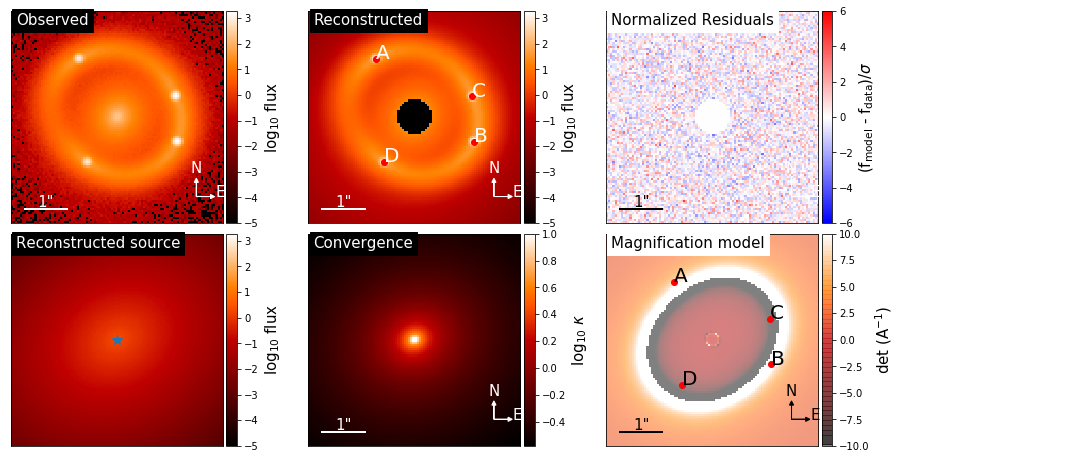

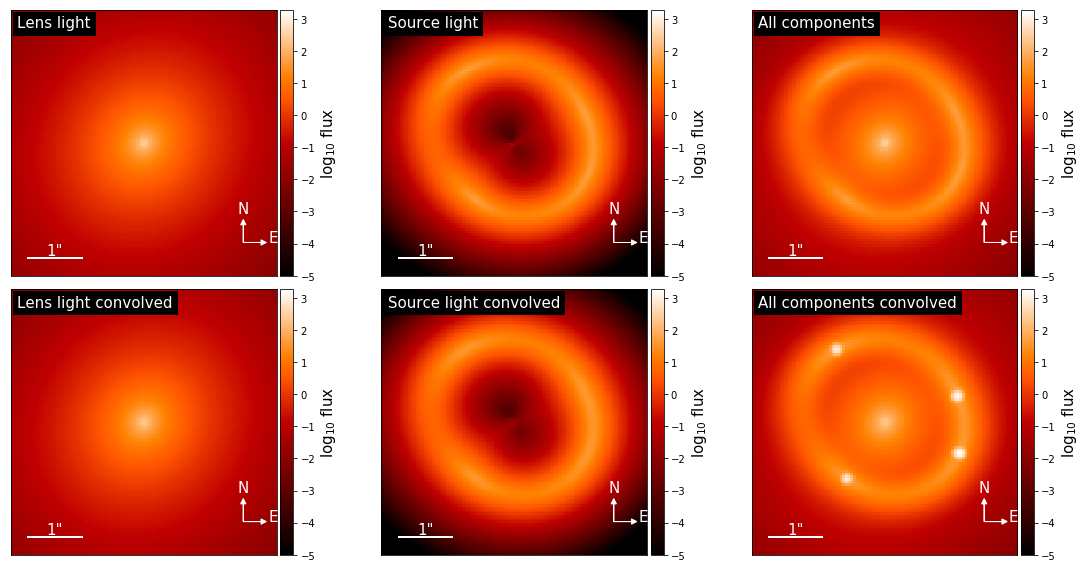

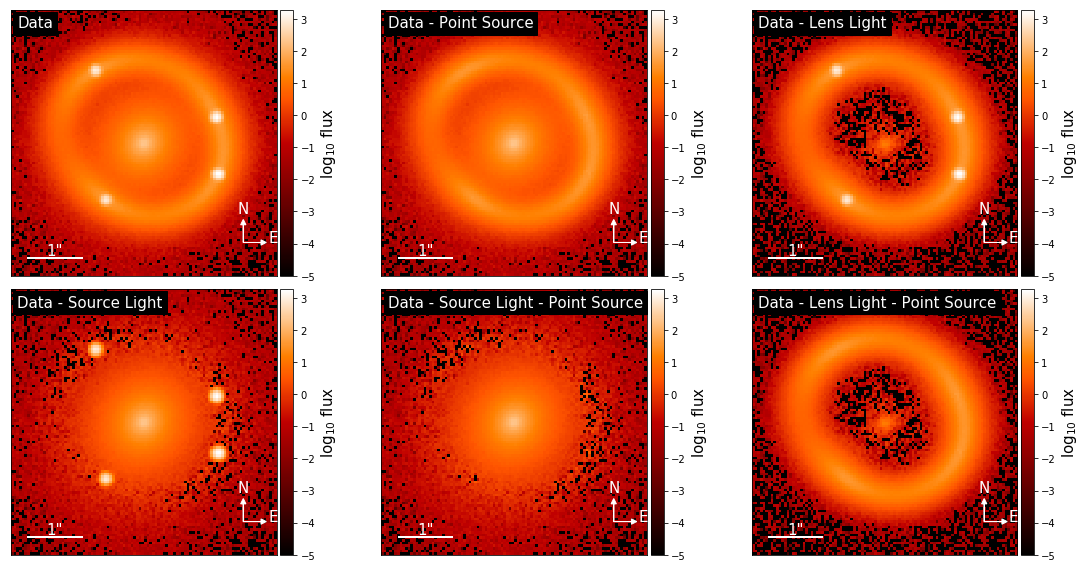

In [16]:
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot

modelPlot = ModelPlot(multi_band_list, kwargs_model_fit, kwargs_result, arrow_size=0.02, 
                      cmap_string="gist_heat", likelihood_mask_list=image_likelihood_mask_list)
    
f, axes = modelPlot.plot_main()
f.show()
f, axes = modelPlot.plot_separate()
f.show()
f, axes = modelPlot.plot_subtract_from_data_all()
f.show()


number of non-linear parameters in the MCMC process:  22
parameters in order:  ['gamma_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'ra_image', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image', 'dec_image', 'D_dt']
number of evaluations in the MCMC process:  88000


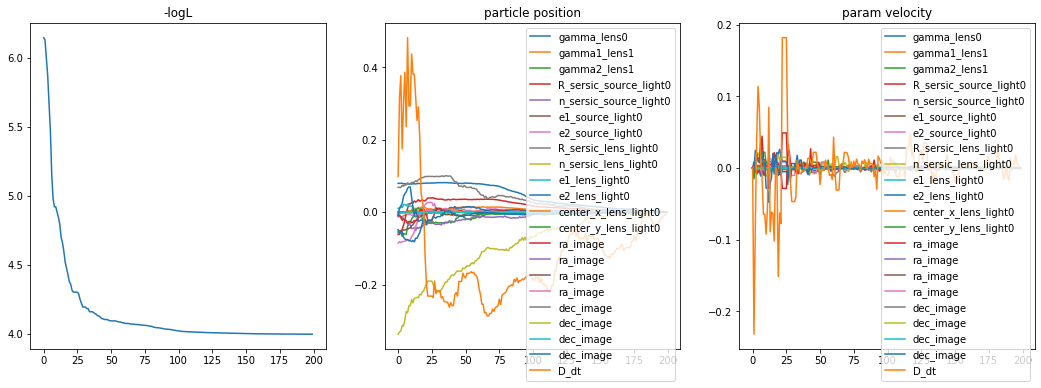

<Figure size 432x288 with 0 Axes>

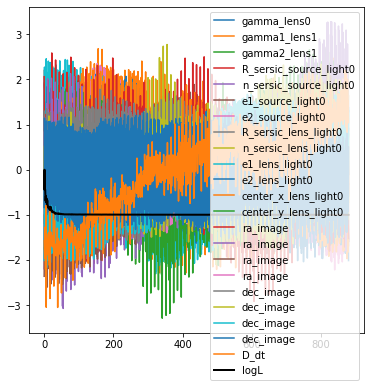

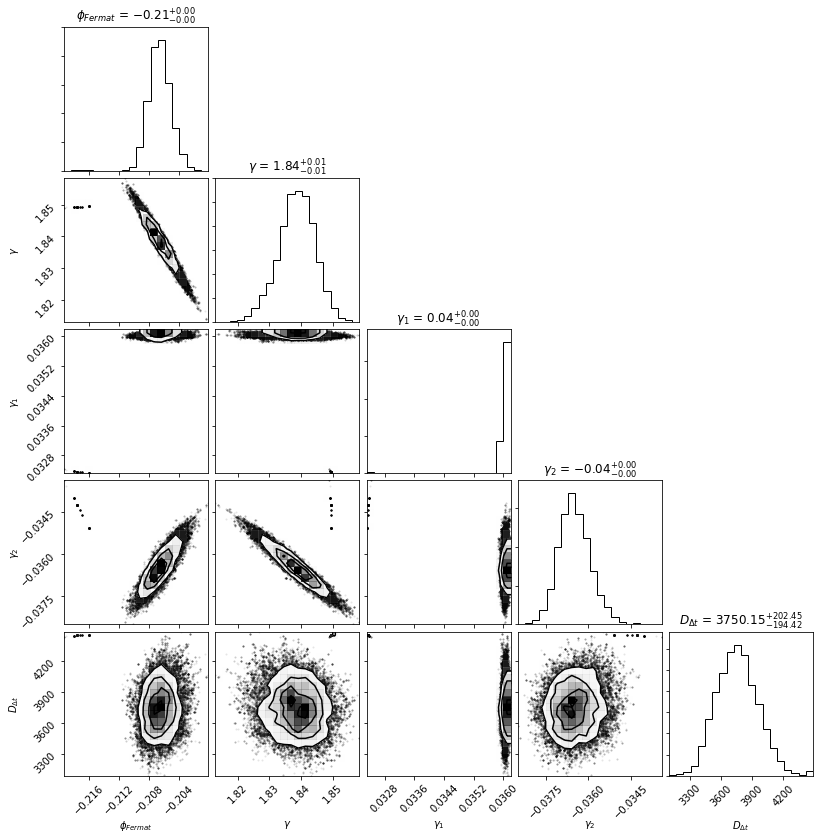

In [17]:
for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)
    
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]

print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
import corner


# import the parameter handling class #
from lenstronomy.Sampling.parameters import Param
# make instance of parameter class with given model options, constraints and fixed parameters #

param = Param(kwargs_model_fit, fixed_lens, fixed_source, fixed_lens_light, fixed_ps, fixed_cosmo, 
              kwargs_lens_init=kwargs_result['kwargs_lens'], **kwargs_constraints)
# the number of non-linear parameters and their names #
num_param, param_list = param.num_param()
td_cosmo_fit = TDCosmography(z_lens, z_source, kwargs_model_fit, cosmo_fiducial=cosmo)

mcmc_new_list = []
labels_new = [r"$\phi_{Fermat}$", r"$\gamma$", r"$\gamma_1$", r"$\gamma_2$", r"$D_{\Delta t}$"]
if cored_model is True:
    labels_new.append(r"s_core")
for i in range(len(samples_mcmc)):
    # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments #
    kwargs_result = param.args2kwargs(samples_mcmc[i])
    D_dt = kwargs_result['kwargs_special']['D_dt']
    fermat_pot = td_cosmo_fit.fermat_potential(kwargs_result['kwargs_lens'], kwargs_result['kwargs_ps'])
    delta_fermat_12 = fermat_pot[0] - fermat_pot[2]
    gamma = kwargs_result['kwargs_lens'][0]['gamma']
    gamma1, gamma2 = kwargs_result['kwargs_lens'][1]['gamma1'], kwargs_result['kwargs_lens'][1]['gamma2']
    if cored_model is True:
        mcmc_new_list.append([delta_fermat_12, gamma, gamma1, gamma2, D_dt, kwargs_result['kwargs_lens'][0]['s_scale']])
    else:
        mcmc_new_list.append([delta_fermat_12, gamma, gamma1, gamma2, D_dt])

mcmc_new_list = np.array(mcmc_new_list)
plot = corner.corner(mcmc_new_list, labels=labels_new, show_titles=True)

In [18]:
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
lensCosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=cosmo)
D_dt_true = lensCosmo.D_dt

kin_api_fit = KinematicAPI(z_lens, z_source, kwargs_model_fit, cosmo=cosmo, lens_model_kinematics_bool=[True, False],
                 light_model_kinematics_bool=[True])

vel_disp_fit = kin_api_fit.velocity_dispersion_numerical(kwargs_result['kwargs_lens'], kwargs_result['kwargs_lens_light'], kwargs_anisotropy, kwargs_aperture,
                                      kwargs_seeing, anisotropy_model, r_eff=r_eff, theta_E=1.66, Hernquist_approx=True,
                                      kwargs_numerics=kwargs_galkin_numerics, MGE_mass=True, kwargs_mge_mass={'n_comp': 20}, kappa_ext=0)
print(vel_disp_fit, 'velocity dispersion in km/s of best fit power-law')
print(vel_disp, 'velocity dispersion in km/s of the true cored model')

205.47539539416684 velocity dispersion in km/s of best fit power-law
163.41159584207855 velocity dispersion in km/s of the true cored model


In [19]:
D_dt_samples = mcmc_new_list[:, 4]
D_dt_mean = np.mean(D_dt_samples)
D_dt_sigma = np.std(D_dt_samples)
print(D_dt_mean, D_dt_sigma)
print('expected bias in H0:',(D_dt_mean - D_dt_true)/D_dt_true)

3756.083262527998 198.5659455851736
expected bias in H0: 0.12806629357011298
